# Brendan Drachler - ASTP-720 Assignment 7

In [61]:
## Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from PyAstronomy.pyasl import foldAt
import warnings
import astropy.units as u


## Optimize for Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Ignore warnings because we are working with complex
## valued numbers at some points - numpy and matplotlib
## throw very bothersome errors. If you are running into
## some crashes, it is best to comment out this line to 
## get better tracebacks.
warnings.filterwarnings('ignore')

# Read in strain data

In [43]:
## Read in the data. WARNING: Don't use np.fromfile!! 
strain_data = np.load('strain.npy')

## The data is given as strain per minute. 
time_minutes = np.arange(1, len(strain_data)+1)

## Calculate what that would be in days and seconds
## for the plots below.
time_days = time_minutes/1440
time_seconds = time_minutes*60

## Calculate the frequency associated with the FFT done below.
time_freq = np.arange(0, len(time_seconds)) * 1/60 * 1/len(time_seconds)

# Plot the strain

Text(0, 0.5, 'Strain $h/10^{-18}$')

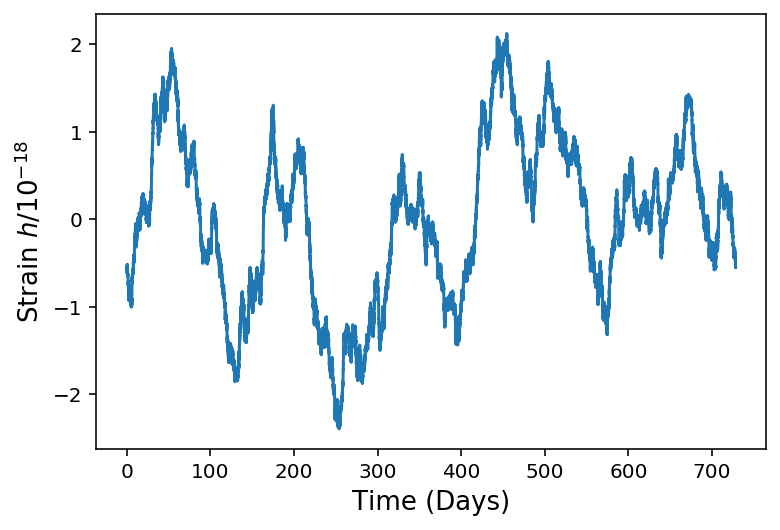

In [44]:
## Plot the strain!
plt.plot(time_days,strain_data/(1e-18))
plt.xlabel('Time (Days)',size=13)
plt.ylabel(r'Strain $h/10^{-18}$',size=13)

# Define the Cooley-Tukey FFT Algorithm as described in Michael Lam's FFT notes.

In [38]:
def Cooley_Tukey_FFT(x, pad_fact):
    '''
    Summary:
    Computes a fast fourier transform using a Cooley-Tukey Algorithm

    Parameters
    ----------
    x : the data to transform.
    pad_fact : the size of N2 when defining the number of
               operations as N = N1*N2. If this is not a 
               padding factor of 2^N it will cause problems!!
    '''
    ## What power of 2^N should we use to recursively compute the
    ## Cooley-Tukey FFT? If N/N_min isn't an integer python will
    ## surely throw an error. This is not a problem in this case 
    ## because the length of strain_data is a factor of 1024. 
    m = np.arange(pad_fact)
    ## In order for the vectorization to work, this has to be a 
    ## a tranposed list. Which is annoying in numpy... This
    ## seems to work.
    k = np.atleast_2d(m).T
    ## Define the exponential term (w^(2km)) in Michael Lam's 
    ## FFT notes (Eq. 16)
    M = np.exp(-2j * np.pi * m * k / pad_fact)
    ## Form an array of exponential terms that has N/N2 rows.
    w_2km = np.dot(M, x.reshape((pad_fact, -1)))
    
    while len(w_2km) < len(x):
        ## Define the even term in Michael Lam's FFT notes (Eq. 18)
        ## Notice this is defined over the half interval to speed things
        ## up according to the Cooley-Tukey Algorithm.
        E_k = w_2km[:, :int(len(w_2km[1]) / 2)]
        
        ## The same applies to the odd terms.
        O_k = w_2km[:, int(len(w_2km[1]) / 2):]
        
        ## Compute Eq. 17 and Eq. 21 of Michael Lam's FFT notes to find
        ## the fourier transform of the data (x).
        w_km = np.exp(-1j * np.pi * np.arange(w_2km.shape[0])/ w_2km.shape[0])[:, None]
        w_2km = np.vstack([E_k + w_km * O_k, E_k - w_km * O_k])

    ## Convert the multidimensional array into a list representing
    ## the fourier transform (Eq. 16 in Michael Lam's FFT notes).
    H_k = w_2km.ravel()
    
    return H_k

# Perform the FFT and plot the result

Text(0, 0.5, 'Amplitude Spectrum |$\\tilde{H}(f)$|')

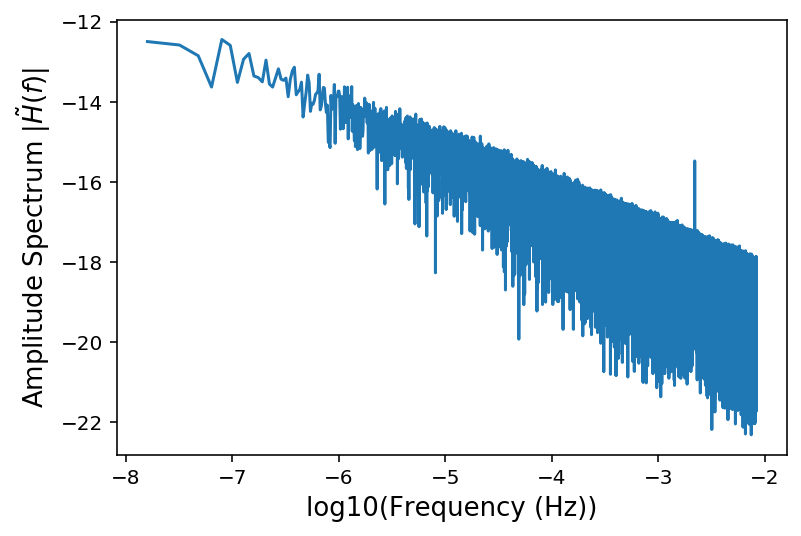

In [57]:
## Perform a FFT on the strain data. 
x_test = Cooley_Tukey_FFT(strain_data,32)
plt.plot(np.log10(time_freq[:int(len(x_test)*0.5)]),np.log10(x_test[:int(len(x_test)*0.5)]))
plt.xlabel('log10(Frequency (Hz))',size=13)
plt.ylabel(r'Amplitude Spectrum |$\tilde{H}(f)$|',size=13)

# Isolate the peak frequency

1.060887671223104e-16

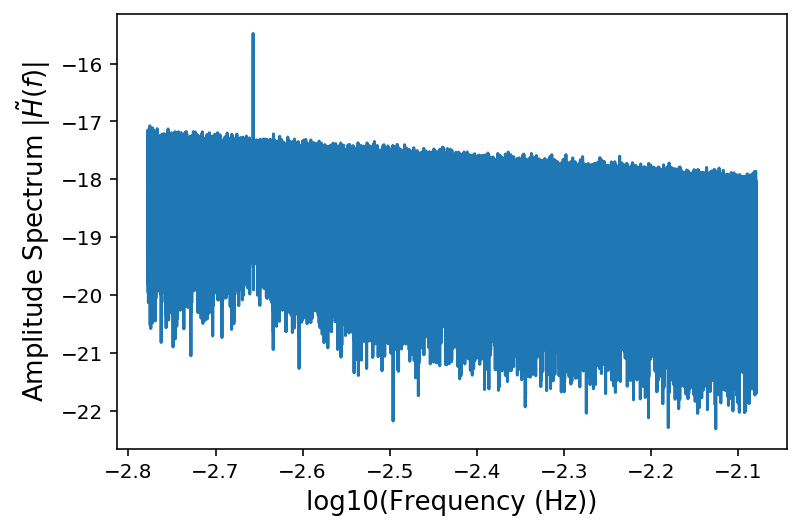

In [77]:
## Plot the region around the frequency peak.
plt.plot(np.log10(time_freq[int(len(x_test)*0.1):int(len(x_test)*0.5)]),np.log10(x_test[int(len(x_test)*0.1):int(len(x_test)*0.5)]))
plt.xlabel('log10(Frequency (Hz))',size=13)
plt.ylabel(r'Amplitude Spectrum |$\tilde{H}(f)$|',size=13)

## Find the index with the peak and the frequency associated with it.
arg = np.argmax(x_test[int(len(x_test)*0.1):int(len(x_test)*0.5)])
freq_peak = time_freq[int(len(x_test)*0.1)+arg]
h_peak = np.real(x_test[int(len(x_test)*0.1)+arg])

h_peak


## Calculate $M$ and $R$ in units of $M_\odot$ and $R_\odot$

In [78]:
distance = 12
M2_R_1 = distance * h_peak / (2.6e-21)
M1_2_R_3_2 = freq_peak / (1e-4)
print(M2_R_1, M1_2_R_3_2)

489640.4636414326 22.037347157796223


## Solving this system of equations...

M2_R_1 $= 489640.46 = M^2 R^{-1}$

and

M1_2_R_3_2 $= 22.04 = M^{1/2} R^{-3/2}$